In [1]:
using Plots
using QuadGK
using LinearAlgebra

In [2]:
aomega(omega) = 1/3 * ( exp(-0.5 * (omega/0.5)^2)/sqrt(2*π*0.5^2) + exp(-0.5 * (omega+5)^2)/sqrt(2*π) + exp(-0.5 * (omega-5)^2)/sqrt(2*π))

aomega (generic function with 1 method)

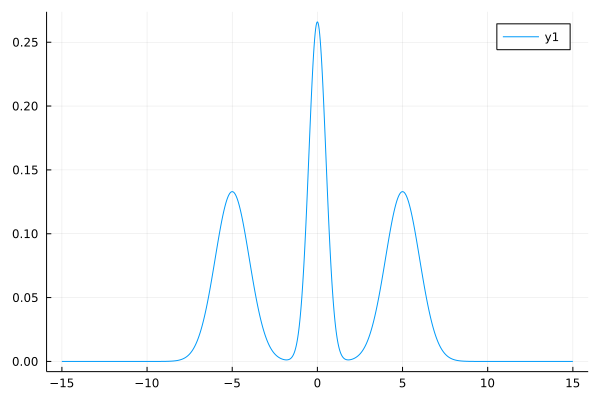

In [3]:
wmax = 15
omegas = LinRange(-wmax, wmax, 1000)
plot(omegas, aomega.(omegas))

In [4]:
##c = quadgk(x -> aomega(x), -wmax, wmax)[1]
##println("normalize=", quadgk(x -> aomega(x), -wmax, wmax)[1])

normalize=1.0000000000000002


# particle

$$
T^{(n)}_p = (-1)^{n+1} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
T^{(n)}_h = (-1)^{n} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
S_n = T[0]^{-1/2} T[n] T[0]^{-1/2}
$$

In [5]:
nmom = 20
Tp = Float64[]
for mom in 0:(nmom-1)
    push!(Tp, quadgk(x -> (x^mom) * aomega(x), 0, wmax)[1])
end
Tp

20-element Vector{Float64}:
      0.5
      1.7331570823746758
      8.708333333333336
     46.699911863504674
    259.3645833333333
   1483.366578527266
   8713.372395833332
  52466.716534456
 323326.7350260417
      2.036366766402356e6
      1.3091773487142071e7
      8.582253358267221e7
      5.731221737563062e8
      3.895481267414682e9
      2.6927994588041332e10
      1.8917671066928473e11
      1.349803472138488e12
      9.775844731343807e12
      7.182588268295525e13
      5.3509461857871375e14

In [6]:
function reconst(T)
    nmom = length(T)
    S = (1/sqrt(T[1])) * T * (1/sqrt(T[1]))
    println(S)

    As = Dict{Int,ComplexF64}()
    Bs = Dict{Int,ComplexF64}()
    Cs = Dict{Tuple{Int,Int},ComplexF64}()

    # Initial values
    As[0] = S[2]
    Bs[0] = 0.0
    Cs[0,0] = 1.0

    function get_S(i)
        i <= nmom-1 ? S[i+1] : 0.0
    end
    
    function get_Cs(n, j)::ComplexF64
        if j < 0 || j > n || n < 0
            return 0.0
        end
        return Cs[(n, j)]
    end

    for n in 0:nmom
        #println("n = $n")
        # Update B[n+1]
        bfirst = sum(conj(Cs[n,l]) * get_S(j+l+1) * get_Cs(n, j-1) for j in 0:(n+1), l in 0:n)
        Bs[n+1] = sqrt(bfirst  - As[n]^2  - conj(Bs[n]^2))

        # C(n+1, j) for j = 0, ..., n+1 (otherwise 0)
        for j in 0:(n+1)
            Cs[(n+1, j)] = (get_Cs(n, j-1) - get_Cs(n, j) * As[n] - get_Cs(n-1, j) * conj(Bs[n])) / Bs[n+1]
        end

        # Update A[n+1]
        As[n+1] = sum(conj(get_Cs(n+1, l) * get_S(j+l+1) * get_Cs(n+1, j)) for j in 0:(n+1), l in 0:(n+1))

        if length(As) >= (nmom + 1) ÷ 2
            break
        end
    end
    return  As, Bs
end

As, Bs = reconst(Tp)


[0.9999999999999998, 3.466314164749351, 17.416666666666668, 93.39982372700933, 518.7291666666665, 2966.733157054531, 17426.74479166666, 104933.43306891198, 646653.4700520833, 4.0727335328047113e6, 2.6183546974284135e7, 1.716450671653444e8, 1.146244347512612e9, 7.790962534829362e9, 5.385598917608265e10, 3.783534213385694e11, 2.6996069442769756e12, 1.955168946268761e13, 1.436517653659105e14, 1.0701892371574274e15]


(Dict{Int64, ComplexF64}(0 => 3.466314164749351 + 0.0im, 4 => 3.9287656760861864 + 0.0im, 5 => 5.160284002282424 + 0.0im, 6 => 5.123318235157058 + 0.0im, 2 => 4.890701396583097 + 0.0im, 7 => 4.736093524843454 + 0.0im, 9 => 5.767118573188782 + 0.0im, 8 => 5.307303339242935 + 0.0im, 3 => 4.109381925379694 + 0.0im, 1 => 2.6485072535145733 + 0.0im…), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 2.5120246330040157 + 0.0im, 5 => 2.2450930271409613 + 0.0im, 6 => 2.1617769684376014 + 0.0im, 2 => 1.5766890085785534 + 0.0im, 7 => 2.594121734238785 + 0.0im, 9 => 2.5846086357920397 + 0.0im, 8 => 2.7428101850239788 + 0.0im, 3 => 1.6969800614253039 + 0.0im, 1 => 2.3240767581826285 + 0.0im…))

In [7]:
nc = length(As)
htri = zeros(ComplexF64, nc, nc)
for i in 1:nc
    htri[i, i] = As[i-1]
end
for i in 1:(nc-1)
    htri[i, i+1] = Bs[i]
    htri[i+1, i] = conj(Bs[i])
end

htri

10×10 Matrix{ComplexF64}:
 3.46631+0.0im  2.32408+0.0im      0.0+0.0im  …      0.0+0.0im      0.0+0.0im
 2.32408-0.0im  2.64851+0.0im  1.57669+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im  1.57669-0.0im   4.8907+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  1.69698-0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im  …      0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im         0.0+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im     2.74281+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im      5.3073+0.0im  2.58461+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im     2.58461-0.0im  5.76712+0.0im

In [8]:
e = eigen(Hermitian(htri))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
10-element Vector{Float64}:
 0.08634237689626888
 0.4224440761079613
 0.9810983331360644
 2.9336609413265
 4.088526140914233
 5.146371854612324
 6.184053060764559
 7.243380739099733
 8.37316389223765
 9.678746675932246
vectors:
10×10 Matrix{ComplexF64}:
 -0.336986-0.0im    -0.40715-0.0im  …   0.0327198-0.0im  0.00263291-0.0im
  0.490088+0.0im     0.53325+0.0im      0.0690818-0.0im  0.00703797-0.0im
 -0.299682-0.0im   -0.152724-0.0im       0.202593-0.0im   0.0275003-0.0im
  0.393089+0.0im  -0.0933176-0.0im       0.351567-0.0im   0.0710534-0.0im
  -0.42709-0.0im    0.240135+0.0im       0.459871-0.0im    0.138954-0.0im
  0.291128+0.0im   -0.270624-0.0im  …    0.516997+0.0im    0.276377-0.0im
  -0.23976-0.0im     0.34372+0.0im       0.290777-0.0im    0.433364-0.0im
  0.222932+0.0im   -0.397343-0.0im     -0.0665546-0.0im    0.530697-0.0im
 -0.151164-0.0im    0.299819+0.0im      -0.363268-0.0im    0.546466+0.0im
 0.06877

In [9]:
weight = real.(conj.(e.vectors[1, :]) .* e.vectors[1, :])

10-element Vector{Float64}:
 0.11355949748126846
 0.16577145130167112
 0.05454946141294279
 0.039946007963446196
 0.19068506336013397
 0.27365802146897206
 0.13746412702150712
 0.023288849555718236
 0.0010705882224152417
 6.93221192484991e-6

In [10]:
sum(weight)

1.0

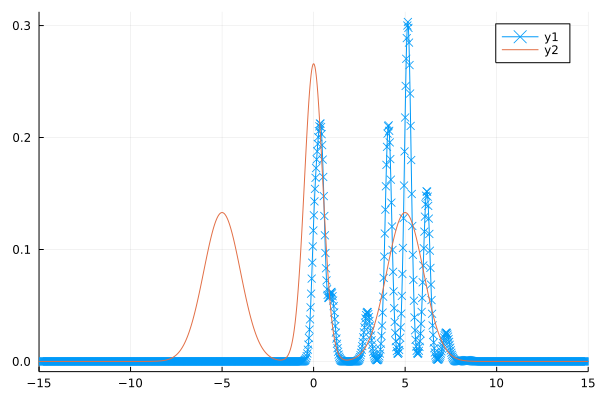

In [44]:
δ = 0.18

#p = 0.25
gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π * δ^2))

cp = quadgk(x -> aomega(x), 0, wmax)[1]
aomega_reconst = zeros(Float64, length(omegas))
for ie in eachindex(e.values)
    aomega_reconst .+= 0.5 * gaussian.(omegas, e.values[ie]) * weight[ie]
end

p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, (aomega_reconst), xlim=(-wmax, wmax), marker=:x)
plot!(p, omegas, aomega.(omegas))

# hole

In [45]:
Th = Float64[]
for mom in 0:(nmom-1)
    push!(Th, quadgk(x -> (x^mom) * aomega(x), -wmax, 0)[1])
end
Th

20-element Vector{Float64}:
      0.5
     -1.7331570823746758
      8.708333333333332
    -46.699911863504674
    259.3645833333333
  -1483.366578527266
   8713.372395833334
 -52466.71653445599
 323326.7350260417
     -2.0363667664023563e6
      1.3091773487142071e7
     -8.582253358267221e7
      5.731221737563062e8
     -3.895481267414682e9
      2.6927994588041336e10
     -1.8917671066928476e11
      1.3498034721384883e12
     -9.775844731343807e12
      7.182588268295525e13
     -5.350946185787138e14

In [46]:
Ash, Bsh = reconst(Th)

[0.9999999999999998, -3.466314164749351, 17.41666666666666, -93.39982372700933, 518.7291666666665, -2966.733157054531, 17426.744791666664, -104933.43306891197, 646653.4700520833, -4.0727335328047117e6, 2.6183546974284135e7, -1.716450671653444e8, 1.146244347512612e9, -7.790962534829362e9, 5.3855989176082664e10, -3.7835342133856946e11, 2.699606944276976e12, -1.955168946268761e13, 1.436517653659105e14, -1.0701892371574275e15]


(Dict{Int64, ComplexF64}(0 => -3.466314164749351 + 0.0im, 4 => -3.928765675984323 + 0.0im, 5 => -5.160284001176478 + 0.0im, 6 => -5.123318225378171 + 0.0im, 2 => -4.890701396583154 + 0.0im, 7 => -4.7360935267060995 + 0.0im, 9 => -5.766988158226013 + 0.0im, 8 => -5.307301506400108 + 0.0im, 3 => -4.109381925376965 + 0.0im, 1 => -2.648507253514584 + 0.0im…), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 2.512024633012788 + 0.0im, 5 => 2.2450930272996774 + 0.0im, 6 => 2.1617769695664304 + 0.0im, 2 => 1.5766890085785374 + 0.0im, 7 => 2.5941217583553224 + 0.0im, 9 => 2.5846145688364635 + 0.0im, 8 => 2.742810063924376 + 0.0im, 3 => 1.6969800614253563 + 0.0im, 1 => 2.324076758182627 + 0.0im…))

In [47]:
nch = length(Ash)
htrih = zeros(ComplexF64, nc, nc)
for i in 1:nch
    htrih[i, i] = Ash[i-1]
end
for i in 1:(nch-1)
    htrih[i, i+1] = Bsh[i]
    htrih[i+1, i] = conj(Bsh[i])
end

htrih

10×10 Matrix{ComplexF64}:
 -3.46631+0.0im   2.32408+0.0im  …      0.0+0.0im       0.0+0.0im
  2.32408-0.0im  -2.64851+0.0im         0.0+0.0im       0.0+0.0im
      0.0+0.0im   1.57669-0.0im         0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im         0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im         0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im  …      0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im         0.0+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im     2.74281+0.0im       0.0+0.0im
      0.0+0.0im       0.0+0.0im     -5.3073+0.0im   2.58461+0.0im
      0.0+0.0im       0.0+0.0im     2.58461-0.0im  -5.76699+0.0im

In [48]:
eh = eigen(Hermitian(htrih))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
10-element Vector{Float64}:
 -9.678731407116063
 -8.37314826817018
 -7.243364686128576
 -6.184036487810059
 -5.146354625066775
 -4.088507922715999
 -2.9336398624409035
 -0.9810903001460513
 -0.4224406749548203
 -0.08634159954579972
vectors:
10×10 Matrix{ComplexF64}:
   0.002633+0.0im  -0.0327207-0.0im  …     0.40715-0.0im   0.336984-0.0im
 -0.0070382-0.0im   0.0690834+0.0im        0.53325+0.0im   0.490086+0.0im
  0.0275012+0.0im   -0.202597-0.0im       0.152726-0.0im   0.299682-0.0im
 -0.0710553-0.0im    0.351571+0.0im     -0.0933125-0.0im   0.393089-0.0im
   0.138957+0.0im   -0.459874-0.0im      -0.240129-0.0im    0.42709-0.0im
  -0.276382-0.0im    0.516995+0.0im  …    -0.27062-0.0im   0.291128-0.0im
    0.43337+0.0im   -0.290767-0.0im      -0.343719-0.0im   0.239762-0.0im
    -0.5307-0.0im  -0.0665675-0.0im      -0.397345-0.0im   0.222935-0.0im
   0.546463+0.0im    0.363275+0.0im      -0.299824-0.0im   0.151167-0

In [49]:
weighth = real.(conj.(eh.vectors[1, :]) .* eh.vectors[1, :])

10-element Vector{Float64}:
 6.932708701974268e-6
 0.0010706449967357225
 0.02328969837975705
 0.13746690044543758
 0.273658912261335
 0.19068213436496023
 0.03994447932281207
 0.054550559402329606
 0.16577119335830112
 0.11355854475962976

In [50]:
sum(weighth)

1.0

ch=0.5


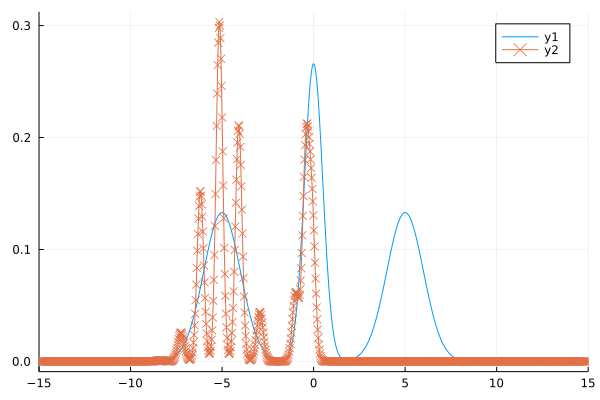

In [51]:
#hole
#δ = 0.2
gaussianh(x, μh) = exp(-0.5 * ((x-μh)/δ)^2)/(sqrt(2π * δ^2))

#hole
ch = quadgk(x -> aomega(x), -wmax, 0)[1]
println("ch=", ch)
aomega_reconsth = zeros(Float64, length(omegas))
for ieh in eachindex(eh.values)
    aomega_reconsth .+= 0.5 * gaussianh.(omegas, eh.values[ieh]) * weighth[ieh]
end


p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, (aomega_reconsth), xlim=(-wmax, wmax), marker=:x)

# whole picture

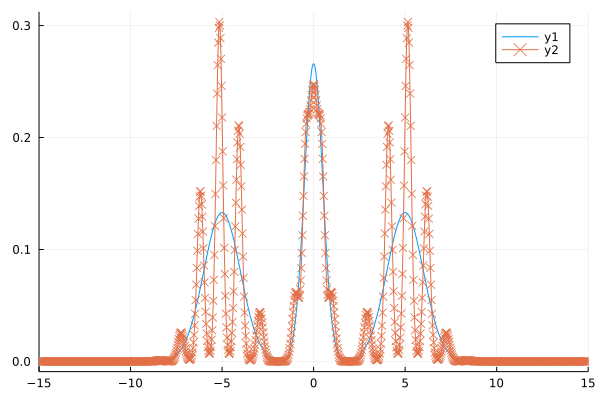

In [52]:
aomega_reconst_all = (aomega_reconst + aomega_reconsth)
#println(aomega_reconst_all)
p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, (aomega_reconst_all), xlim=(-wmax, wmax), marker=:x)
#plot!(p, omegas, (aomega_reconsth),  xlim=(-wmax, wmax), maker=:x)


In [53]:
delta = 15

15

In [24]:
savefig("nmom=20,$(delta)")

In [25]:
savefig("nmom=$(nmom)")